# 1. RNN for Language Modeling (4pt)

 -  Import the torchtext IMDB dataset and do the following:
   -  Build a  Markov (n-gram) language model.
   -  Change the output and the model appropriately in _[Simple Sentiment Analysis.ipynb](https://github.com/bentrevett/pytorch-sentiment-analysis)_ (also available [here](https://github.com/thejat/dl-notebooks/blob/master/examples/rnn/Seq2Seq_RNN_Simple_Sentiment_Analysis.ipynb) where the imports have been slightly modified) to build an LSTM based language model. Plot the training performance as a function of epochs/iterations.
 -  For each model, describe the key design choices made. Briefly mention how each choice influences training time and generative quality.
 -  For each model, starting with the phrase "My favorite movie ", sample the next few words and create an approx. 20 word generated review. Repeat this 5 times (you should ideally get different outputs each time) and report the outputs.
 - Note: make any assumptions as necessary.

## `torchtext` IMDB dataset
We begin by setting up the `torch` environment and downloading the `IMDB` dataset from the `torchtext.data.Dataset` class. The `torchtext` dataset is preprocessed into a into a collection of lists of tokens.

In [1]:
import torch
from torch import mps

import torchtext
from torchtext import datasets

from nltk.tokenize import word_tokenize
import re

# make torch deterministic for reproducibility
seed = 576
torch.manual_seed(seed)

# set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Torch Device:", device)

Torch Device: mps


In [2]:
# train model on training split
train_iter = datasets.IMDB(split="train")

# initialize a list to store reviews
reviews = []

# append each review
for _, review in train_iter:
    reviews.append(review)

# initialize list to store tokenized reviews
tokenized_reviews = []

# preprocess and tokenize reviews
for review in reviews:
    lowercase_review = review.lower()
    cleaned_review = re.sub(r'[^A-Za-z0-9\s]+', '', lowercase_review.replace('<br />', ' '))
    tokenized_reviews.append(word_tokenize(cleaned_review))

## Markov (n-gram) Language Model

A _Markov (n-gram)_ language model is a purely statistical character-level model. The model is based on the assumption that the probability of the next word in a sequence is based on the history _h_ of the preceding words in the sequence. For a set number _n_ of immediately previous words (or tokens) in the sequence, this assumption can be expressed as:

$$P(w|h)\approx P(w_n|w_{1:n-1})$$

A _bigram_ is specific _n-gram_ case (_n_ = 2) where the conditional probability of the next word in a sequence is dependent solely on the preceding word in the sequence

$$P(w|h)\approx P(w_n|w_{n-1})$$

We can further generalize this propoerty to _trigrams_ (_n_ = 3) such that the conditional probability of the next word in a sequence is

$$P(w|h)\approx P(w_n|w_{n-2, n-1})$$

Let us create a general python class `build_random_ngram_model` that replicates the above funtionality with the IMBD dataset. In order to reduce recursive, repeating predicitons, the `predic()` method introduces randomness to the model, using a weighted choice between all tokens $w_n$ that correspond to a certain context $w_{1:n-1}$. The method parameter `rand` allows us to select the top `rand` weighted words from the model.

In [3]:
from nltk.util import ngrams
from tqdm import tqdm
import random

class build_random_ngram_model():

    '''
    This class builds a Markov (n-gram) language model.
    '''
    def __init__(self, tokenized_reviews: list, n: int = 2):
        self.n = n
        self.model = self._build_model(tokenized_reviews, n=n)

    def _build_model(self, tokenized_reviews, n):

        # empty return model
        model = {}

        # build model
        print("builing model...")
        for review in tqdm(tokenized_reviews):

            # build n-grams from reviews
            for ngram in ngrams(review, n, pad_right=True, pad_left=True):
                context = tuple(ngram[:-1])
                target = ngram[-1]

                # check if context is already in the model
                if context not in model:
                    model[context] = {}

                # get frequency counts of co-occurrence
                if target not in model[context]:
                    model[context][target] = 1
                else:
                    model[context][target] += 1

        # convert frequency counts to probabilities
        for context in model:
            count = float(sum(model[context].values()))
            for target in model[context]:
                model[context][target] /= count

        # return trained model
        print("done!")
        return model

    def get_model(self) -> dict:

        '''
        Returns model stored as dict.
        '''

        return self.model

    def predict(self, words: str, rand: int = None) -> str:

        '''
        This function returns the next word given the input string.
        Randomly select out of the top rand probabilities given a certain context.
        '''

        # get last n-1 words in string
        key = tuple(words.split())[1-self.n:]

        # get top keys in dictionary
        top_keys = sorted(self.model[key], key = self.model[key].get, reverse=True)[:rand]

        # get probs of top keys
        top_values = [self.model[key][top_key] for top_key in top_keys]

        # select random key
        selected_key = random.choices(top_keys, weights = top_values, k=1)[0]

        return selected_key

    def complete(self, words: str, rand: int = None) -> str:

        '''
        This function returns the entire string with the predicted next word
        '''

        next_word = self.predict(words, rand = rand)

        # if context does not exist in model dict return original words
        if next_word is not None:
            completed_string = words+" "+next_word
        else:
            completed_string = words

        return completed_string

    def review(self, words: str, l = 10, rand: int = None) -> str:

        '''
        This function completes a review for an additional l words.
        '''

        working_words = words

        i = 0

        while i < l:
            working_words = self.complete(working_words, rand = rand)
            i += 1

        return working_words

We can now build a trigram language model and generate random reviews from the input string `My favorite movie`.

In [4]:
trigram_model = build_random_ngram_model(tokenized_reviews, 3)

for i in range(5):
    generated_text = trigram_model.review("My favorite movie", 17)
    print(f"Review {i+1}: {generated_text}")

builing model...


100%|██████████| 25000/25000 [00:03<00:00, 6375.82it/s]


done!
Review 1: My favorite movie as i do recommend the movie first i thought no spoilers ok is killed in the first
Review 2: My favorite movie i like to see this movie without relying solely on the back for the murder of the
Review 3: My favorite movie this doubles as a much better with a rousing boxing match and told his first version
Review 4: My favorite movie i liked this lighthearted sometimes genre challenged mini series is plotwise the haunting as so poorly scripted
Review 5: My favorite movie makers from ed wood jr is an inarticulated understanding it i never really connects with the oscarnominated


## LSTM Based Language Model

For the LSTM based language model we shall be following along with [Seq2Seq_LSTM_Simple_Sentiment_Analysis.ipynb](https://github.com/thejat/dl-notebooks/blob/master/examples/rnn/Seq2Seq_LSTM_Simple_Sentiment_Analysis.ipynb) and making modifications as neccessary.

First we download the `"train"` and `"test"` splits from the `IMDB` dataset and check the size of each split. For the sake of computational complexity, the training dataset is reduced to 2,000 instance and the validation dataset is reduced to 200.

In [5]:
from torch.utils.data import Subset

train_n = 3000
valid_n = 300

train_dataset_raw = datasets.IMDB(split="train")
valid_dataset_raw = datasets.IMDB(split="test")

train_dataset = Subset(list(train_dataset_raw), range(train_n))
valid_dataset = Subset(list(valid_dataset_raw), range(valid_n))

print("Train dataset size: ",len(list(train_dataset)))
print("Test dataset size: ",len(list(valid_dataset)))

Train dataset size:  3000
Test dataset size:  300


### Data Preprocessing Pipeline
We next construct utilities to aid in the preprocessing of the `IMDB` dataset. Since we are creating a language model, our preprocessing pipeline must result in the generation of an _input sequence_ and _target sequence_. The _input sequence_ and _target sequence_ differ only by one "time-step".

$$X_{Raw} =[x_1, x_2, \ldots, x_T]$$
$$X_{Input} = [x_1, x_2, \ldots, x_{T-1}]$$
$$X_{Target} = [x_2, x_3, \ldots, x_{T}]$$

The first utility is the `tokenizer()`, that parses through string instances in the datasets and converts to tokens.

In [6]:
def tokenizer(text):
    # step 1. remove HTML tags. they are not helpful in understanding the sentiments of a review
    # step 2: use lowercase for all text to keep symmetry
    # step 3: extract emoticons. keep them as they are important sentiment signals
    # step 4: remove punctuation marks
    # step 5: put back emoticons
    # step 6: generate word tokens
    text = re.sub("<[^>]*>", "", text)
    text = text.lower()
    emoticons = re.findall("(?::|;|=)(?:-)?(?:\)|\(|D|P)", text)
    text = re.sub("[\W]+", " ", text)
    text = text + " ".join(emoticons).replace("-", "")
    tokenized = text.split()
    return tokenized

We next create a utility to obtain `token_counts` from the dataset.

In [7]:
from collections import Counter

token_counts = Counter()

for _, line in iter(train_dataset):
    tokens = tokenizer(line)
    token_counts.update(tokens)

print('IMDB train dataset vocab size:', len(token_counts))

IMDB train dataset vocab size: 28361


The tokens are then sorted by frequency and converted to to integers using the `vocab` object. For the sake of computational complexity the first 1,000 words of the ordered dictionary by freqeuency are used for the model vocabulary.

In [8]:
from collections import OrderedDict
from torchtext.vocab import vocab

sorted_by_freq_tuples = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

reduced_ordered_dict = OrderedDict()

count = 0
for key, value in ordered_dict.items():
    reduced_ordered_dict[key] = value
    count += 1

    if count == 1000:
        break

vb = vocab(reduced_ordered_dict)

vb.insert_token("<pad>", 0)  # special token for padding
vb.insert_token("<unk>", 1)  # special token for unknown words
vb.set_default_index(1)

# print some token indexes from vocab
for token in ["this", "is", "an", "example"]:
    print(token, " --> ", vb[token])

this  -->  11
is  -->  7
an  -->  38
example  -->  417


Inline lambda functions are then used for text processing. This is the first major deviation from the source code; to create _input sequences_ and _target sequences_ from the raw dataset.

In [9]:
input_pipeline = lambda x: [vb[token] for token in tokenizer(x)][:-1]
target_pipline = lambda x: [vb[token] for token in tokenizer(x)][1:]

length = 5
print("Example Sequences")
for i in list(train_dataset_raw)[:4]:
    example_tokens = tokenizer(i[1])[:length+1]
    example_input = input_pipeline(i[1])[:length]
    example_target = target_pipline(i[1])[:length]

    print(f'Sample Tokens: {example_tokens}')
    print(f'Input Sequence: {example_input}')
    print(f'Target Sequence: {example_target}', "\n")

Example Sequences
Sample Tokens: ['i', 'rented', 'i', 'am', 'curious', 'yellow']
Input Sequence: [9, 1, 9, 242, 1]
Target Sequence: [1, 9, 242, 1, 1] 

Sample Tokens: ['i', 'am', 'curious', 'yellow', 'is', 'a']
Input Sequence: [9, 242, 1, 1, 7]
Target Sequence: [242, 1, 1, 7, 3] 

Sample Tokens: ['if', 'only', 'to', 'avoid', 'making', 'this']
Input Sequence: [43, 58, 6, 511, 211]
Target Sequence: [58, 6, 511, 211, 11] 

Sample Tokens: ['this', 'film', 'was', 'probably', 'inspired', 'by']
Input Sequence: [11, 21, 14, 245, 1]
Target Sequence: [21, 14, 245, 1, 37] 



The preprocessing utilities will be applied at the batch level, as a `collate_fn` argument. The source code is modified to return the input and target sequences. Since these sequences are of the same length, we do not need to return length

In [10]:
import torch.nn as nn

def collate_batch(batch):
    input_list, target_list, = [], []

    # iterate over all reviews in a batch
    for _, _text in batch:

        # input preprocessing
        processed_input = torch.tensor(input_pipeline(_text), dtype=torch.int64)

        # target preprocessing
        processed_target = torch.tensor(input_pipeline(_text), dtype=torch.int64)


        # store the processed text in input and target lists
        input_list.append(processed_input)
        target_list.append(processed_target)

    # pad the processed reviews to make their lengths consistant
    padded_input_list = nn.utils.rnn.pad_sequence(
        input_list, batch_first=True)

    padded_target_list = nn.utils.rnn.pad_sequence(
        target_list, batch_first=True
    )

    # return
    # 1. a list of processed and padded input texts
    # 2. a list of processed and padded target texts
    # 3. a list of review text original lengths (before padding)
    return padded_input_list.to(device), padded_target_list.to(device)

### Batching the Training, Validation, and Test Datasets
The `IMDB` Datasets are loaded into torch `DataLoader()` objects with the above `collate_batch()` function.

In [11]:
from torch.utils.data import DataLoader
batch_size = 32

train_dl = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch
)
valid_dl = DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch
)

### RNN Model Configuration

We will now modify the source code's sentiment analysis `RNN` class for the purposes of language modeling. An overview of the architecture and design choices made to implement this are as follows:
- An **Embedding layer** as as explained by the source code.
- An **LSTM layer**  to capture long range dependencies and relationships in the text.
- A **Fully Connected layer** to obtain `logits`, the raw unnormalized predictions for each token at each "time step" in the model.

In [12]:
# create langauge model class
class RNN_Language(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.LSTM(embed_dim, vocab_size)#, batch_first=True)

    def forward(self, input_sequence):
        out = self.embedding(input_sequence)
        out.size()
        out, _ = self.rnn(out)
        out.view(-1, vocab_size)
        return out

# instantiate a model
vocab_size = len(vb)
embed_dim = 20

torch.manual_seed(576)
model = RNN_Language(vocab_size, embed_dim)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 4124232


### Loss Function, Optimizer and Training Loop

We will utilize `CrossEntropyLoss()` as our loss function and the `Adam()` algorithm for optimization.

In [13]:
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

model.to(device)

num_epochs = 10

# training loop

def train(model, train_dl, valid_dl):

    train_history, valid_history = [], []

    for epoch in range(num_epochs):

        print(f"Epopch: {epoch}")

        model.train()
        total_loss, valid_loss = 0, 0

        # training
        for input_batch, target_batch in tqdm(train_dl):
            with torch.set_grad_enabled(True):
                # forward pass
                optimizer.zero_grad()
                logits = model(input_batch)
                loss = criterion(logits.view(-1, vocab_size), target_batch.view(-1))

                # backwards pass
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * batch_size

        avg_loss = total_loss / len(train_dl.dataset)
        train_history.append(avg_loss)
        print(f"Training loss:\t{avg_loss}")

        # validation
        for input_batch, target_batch in valid_dl:
            with torch.no_grad():
                logits = model(input_batch)
                loss = criterion(logits.view(-1, vocab_size), target_batch.view(-1))

            valid_loss += loss.item() * batch_size

        avg_valid_loss = valid_loss / len(valid_dl.dataset)
        valid_history.append(avg_valid_loss)
        print(f"Validation Loss\t{avg_valid_loss}\n")


    return train_history, valid_history

In [14]:
train_history, valid_history = train(model, train_dl, valid_dl)

Epopch: 0


100%|██████████| 94/94 [00:32<00:00,  2.93it/s]


Training loss:	5.8993025970458985
Validation Loss	6.193797149658203

Epopch: 1


100%|██████████| 94/94 [00:30<00:00,  3.07it/s]


Training loss:	5.746737116495768
Validation Loss	6.12672597249349

Epopch: 2


100%|██████████| 94/94 [00:30<00:00,  3.11it/s]


Training loss:	5.685356465657552
Validation Loss	6.0741440836588545

Epopch: 3


100%|██████████| 94/94 [00:29<00:00,  3.14it/s]


Training loss:	5.6424459431966145
Validation Loss	6.0267330932617185

Epopch: 4


100%|██████████| 94/94 [00:29<00:00,  3.19it/s]


Training loss:	5.605587712605795
Validation Loss	5.990525512695313

Epopch: 5


100%|██████████| 94/94 [00:28<00:00,  3.28it/s]


Training loss:	5.572761591593425
Validation Loss	5.961965637207031

Epopch: 6


100%|██████████| 94/94 [00:30<00:00,  3.08it/s]


Training loss:	5.550545827229818
Validation Loss	5.941821034749349

Epopch: 7


100%|██████████| 94/94 [00:32<00:00,  2.89it/s]


Training loss:	5.535897120157878
Validation Loss	5.92263676961263

Epopch: 8


100%|██████████| 94/94 [00:31<00:00,  2.97it/s]


Training loss:	5.514369654337565
Validation Loss	5.8882738240559895

Epopch: 9


100%|██████████| 94/94 [00:30<00:00,  3.12it/s]


Training loss:	5.456739624023437
Validation Loss	5.782337443033854



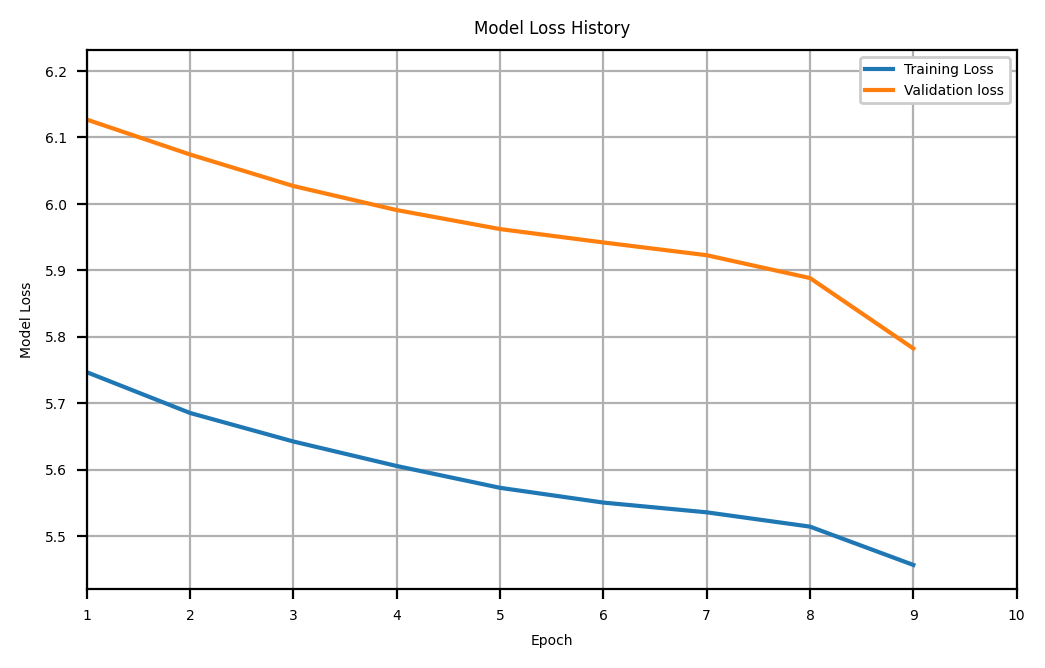

In [15]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 5})

# plot loss history
fig, ax = plt.subplots(figsize=(6,3.5), dpi=200)

ax.plot(
        train_history,
        label = r'Training Loss',
        #marker = 'o',
        markersize = 4)

ax.plot(
        valid_history,
        label = r'Validation loss',
        #marker = 'o',
        markersize = 4)

ax.set_title("Model Loss History")
ax.set_xlabel('Epoch')
ax.set_ylabel('Model Loss')
ax.set_xlim(1, len(train_history))
ax.legend()
ax.legend().get_frame().set_alpha(1.0)

ax.grid(True)

### Training and Evaluation Pipelines

In [27]:
import torch.nn.functional as F

def generate_text(model, text, max = 17, adjust = 1):
    # set model to evaluation
    model.eval()

    # copy input string
    input = text

    # iterate max times
    for _ in range(max):

        # convert to tensor tokens
        text_tokens = [vb[token] for token in tokenizer(input)]
        tensor_tokens = torch.tensor(text_tokens, dtype = torch.int64).to(device)

        # evaluate on model and adjust by scalar to add addtional randomness
        with torch.no_grad():
            logits = model(tensor_tokens)[-1,:] / adjust

        # convert to probabilies
        probs = F.softmax(logits, dim=-1)

        # use multinomial distribution to select index of next word based on probs
        choice = torch.multinomial(probs, 1).item()

        # obtain next word from vb
        next_word = vb.lookup_token(choice)

        # append to end of input string
        input = input+" "+next_word

    return input

for i in range(5):
    generated_text = generate_text(model, "My favorite movie", 17, 10)
    print(f"Review {i+1}: {generated_text}")

Review 1: My favorite movie up mean screen laughs not 5 writers sadly cause gets falls okay dramatic dvd wish waste matter
Review 2: My favorite movie lack disappointing behind cast goes moments watch lost mark expected enjoy might no anyway feature project really
Review 3: My favorite movie sense plain though everyone experience live any laughs run killer sort utterly power local real nothing work
Review 4: My favorite movie pretty animation gave writing freddy dramatic couldn have cheap tries fighting hitler makes save anyway rent fact
Review 5: My favorite movie apart me once 3 lady films children mad scary whose interest game lack sense while given it
